
# Matemáticas para Ciencias de los Datos
### Regresión con descenso de gradiente utilizando Pytorch 

### Profesora: María Auxiliadora Mora

Documento base: (Godoy, 2019)

# Objetivo

El objetivo de este documento es introducir a los estudiantes en el uso de la biblioteca de Pytorch por medio de un ejemplo simple de regresión lineal usando descenso de gradiente implementado paso a paso.


## Dependencias

In [10]:
# Bibliotecas requeridas para el ejercicio

#!pip install torch
import torch as torch

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

#import torch
import torch.optim as optim
import torch.nn as nn


# Descenso de gradiente

En el siguiente ejemplo se aproximará un conjunto de puntos con una función de la forma $h(x)= a + bx $. Se va a utilizar el descenso de gradiente para encontrar el a y el b que mejor se ajusten a los datos.

El descenso de gradiente es un algoritmo de optimización iterativo que nos permite calcular un mínimo local de una función diferenciable. Para encontrar un mínimo local de una función usando la pendiente del gradiente, se realizan los siguientes pasos con muchas pasadas. Cada pasada de entrenamiento se denomina una época: 

## 1) Se calcula la pérdida
Existen muchas funciones para medir la pérdia. Para un problema de regresión, la pérdida se puede medir usando el error cuadrático medio (MSE), es decir, el promedio de todas las diferencias cuadráticas entre las etiquetas $(y)$ y las predicciones $(a + bx)$.
$$
MSE =  \frac {1}{N}\sum_{i=1}^{N}(y_{i}-\hat{y}_{i})^{2}
$$
Esto es igual a:
$$
MSE =  \frac {1}{N} \sum_{i=1}^{N}(y_{i}-a-bx_{i})^{2}
$$

Con N el número de muestras $\hat{y}_{i}$ es la salida del modelo y ${y}_{i}$ es el target o la salida conocida para ${x}_{i}$. Entonces se suman todas las diferencias entre la salida y el target y se dividen entre N.

Note que, si se utilizan todos los puntos del conjunto de entrenamiento (N) para calcular la pérdida, se está realizando un descenso de gradiente por lotes. Si se utiliza un solo punto a la vez, se está calculando un descenso de gradiente estocástico. Cualquier otro cálculo que involucre una cantidad de puntos entre 1 y N caracteriza un descenso de gradiente utilizando mini lotes.

## 2) Se calcula el vector gradiente 
Se calculan las derivadas parciales en a y b:
$$
 \displaystyle \frac{\partial MSE}{\partial a} =  \frac {1}{N}\sum_{i = 1}^{N} 2(y_{i}-a-bx_{i})(-1) = -2 \frac {1}{N} \sum_{i = 1}^{n} (y_{i}-\hat{y}_{i})
$$

$$
 \displaystyle \frac{\partial MSE}{\partial b} = \frac {1}{N} \sum_{i = 1}^{N} 2(y_{i}-a-bx_{i})(-x_{i}) = -2 \frac {1}{N} \sum_{i = 1}^{n} (x_{i})(y_{i}-\hat{y}_{i})
$$

## 3) Se actualizan los parámetros a y b
En el paso final, se utiliza el valor de los gradientes para actualizar los parámetros. Como se está tratando de minimizar la pérdida, se invierte el signo del gradiente para la actualización.

Se debe definir la tasa de aprendizaje ($\eta $), que es el factor multiplicativo que se le aplica al gradiente para la actualización del parámetro. 

$$
a = a - \displaystyle \eta \frac{\partial MSE}{\partial a}
$$

$$
b = b - \displaystyle \eta \frac{\partial MSE}{\partial b}
$$

# Ejemplo de regresión lineal simple

Índice

Regresión lineal simple usando descenso de gradiente basada en [1] 
- a. Generación de los datos
- b. Ajuste de parámetros con descenso de gradiente
- c. Uso de optimizadores
- d. Cálculo de la pérdida o error
- e. Evaluación del modelo resultante

In [11]:
# Generación de datos aleatorios: un vector de 100 puntos que representan 
# una característica x, a = 1, b = 2, y epsilon representado como ruido gaussiano. 

# Generación de los valores de x de forma aleatoria
np.random.seed()
x = np.random.rand(100, 1)
y = 1 + 2 * x + .2 * np.random.randn(100, 1)

# Generación de los índices "barajados"
idx = np.arange(100)
np.random.shuffle(idx)

# b. Separación de los datos de la muestra en datos de prueba y datos para la regresión.
# División de la muestra en 80 datos para ajuste de parámetros y 20 datos para pruebas.
train_idx = idx[:80]
# indices del 80 al final 
val_idx = idx[80:]

# Genera los conjuntos de validación y ajuste de parámetros
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]


/tmp/ipykernel_9776/706496237.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(x_val, y_val, 'go', label='Validación', alpha=0.5, color='red')


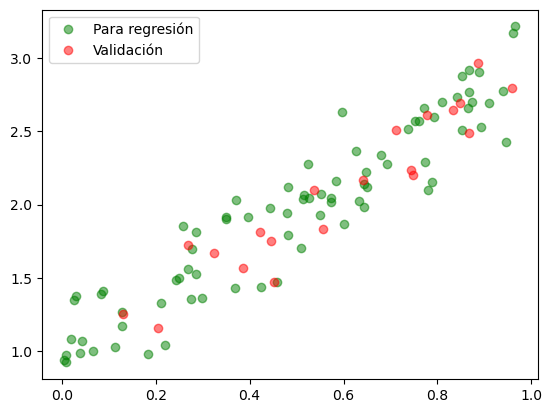

In [12]:
# Graficación de los datos
def plot_data(x_train, y_train, x_val, y_val):
    """ 
    Grafica los datos en dos dimensiones.
    param: x_train, y_train. Datos de entrenamiento.
    param: x_val, y_val. Datos para la validación.
    return: sin valor de retorno. 
    """    
    # Inicializa la figura
    plt.clf()

    #Grafica los datos para el ajuste de parámetros y validación
    plt.plot(x_train, y_train, 'go', label='Para regresión', alpha=0.5)
    plt.plot(x_val, y_val, 'go', label='Validación', alpha=0.5, color='red')
    plt.legend(loc='best')
    plt.show()

plot_data(x_train, y_train, x_val, y_val)    

In [13]:
# Seleccionar el dispositivo
# Convertir los datos en tensores de PyTorch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Los datos están almacenados en matrices Numpy, hay que transformarlos 
# a tensores de PyTorch.
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)



In [15]:
# Se requiere una función h que represente muy bien los datos,
# por lo que inicialmente los parámetros a y b van a tener un valor aleatorio. 
# Luego hay que ajustar el valor de a y b que mejor aproxima los datos.

torch.seed()
# Retorna un tensor con un dato
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

print("a y b aleatorios")
print(a, b)

a y b aleatorios
tensor([-0.6142], requires_grad=True) tensor([0.4199], requires_grad=True)


In [16]:
# Cálculo del gradiente, la pérdida y actualización de a y b manualmente

# Factor de aprendizaje 
lr = 1e-1

# Cantidad de veces que se van a ajustar los pesos
n_epochs = 1000

# Convergencia 
for epoch in range(n_epochs):

    # Salida de la función.
    yhat = a + b * x_train_tensor
    
    #Cálculo de la pérdida
    error = y_train_tensor - yhat
    #print(error)
    # El gradiente calculado de forma manual
    a_grad = -2 * error.mean()
    b_grad = -2 * (x_train_tensor * error).mean()
    
    # Verificamos los gradientes.
    #print("Gradiente de a", a_grad)
    #print("Gradiente de b", b_grad)
    
    # Se actualiza los parámetros 
    # Se necesita la opción NO_GRAD para no afectar el grafo de computación dinámica 
    # que mantiene Pytorch.
    with torch.no_grad():
      a -= lr * a_grad
      b -= lr * b_grad    
    print("Valor de a:", a)
    print("Valor de b",  b)    

print("Valor de a final:", a)
print("Valor de b final",  b)

  

Valor de a: tensor([-0.1412], requires_grad=True)
Valor de b tensor([0.6805], requires_grad=True)
Valor de a: tensor([0.2113], requires_grad=True)
Valor de b tensor([0.8768], requires_grad=True)
Valor de a: tensor([0.4738], requires_grad=True)
Valor de b tensor([1.0250], requires_grad=True)
Valor de a: tensor([0.6690], requires_grad=True)
Valor de b tensor([1.1373], requires_grad=True)
Valor de a: tensor([0.8141], requires_grad=True)
Valor de b tensor([1.2227], requires_grad=True)
Valor de a: tensor([0.9216], requires_grad=True)
Valor de b tensor([1.2880], requires_grad=True)
Valor de a: tensor([1.0011], requires_grad=True)
Valor de b tensor([1.3383], requires_grad=True)
Valor de a: tensor([1.0598], requires_grad=True)
Valor de b tensor([1.3773], requires_grad=True)
Valor de a: tensor([1.1028], requires_grad=True)
Valor de b tensor([1.4080], requires_grad=True)
Valor de a: tensor([1.1341], requires_grad=True)
Valor de b tensor([1.4323], requires_grad=True)
Valor de a: tensor([1.1568], 

Valor de a: tensor([1.0027], requires_grad=True)
Valor de b tensor([1.9247], requires_grad=True)
Valor de a: tensor([1.0027], requires_grad=True)
Valor de b tensor([1.9247], requires_grad=True)
Valor de a: tensor([1.0027], requires_grad=True)
Valor de b tensor([1.9247], requires_grad=True)
Valor de a: tensor([1.0027], requires_grad=True)
Valor de b tensor([1.9247], requires_grad=True)
Valor de a: tensor([1.0026], requires_grad=True)
Valor de b tensor([1.9247], requires_grad=True)
Valor de a: tensor([1.0026], requires_grad=True)
Valor de b tensor([1.9248], requires_grad=True)
Valor de a: tensor([1.0026], requires_grad=True)
Valor de b tensor([1.9248], requires_grad=True)
Valor de a: tensor([1.0026], requires_grad=True)
Valor de b tensor([1.9248], requires_grad=True)
Valor de a: tensor([1.0026], requires_grad=True)
Valor de b tensor([1.9248], requires_grad=True)
Valor de a: tensor([1.0026], requires_grad=True)
Valor de b tensor([1.9248], requires_grad=True)
Valor de a: tensor([1.0026], r

Valor de b tensor([1.9258], requires_grad=True)
Valor de a: tensor([1.0021], requires_grad=True)
Valor de b tensor([1.9258], requires_grad=True)
Valor de a: tensor([1.0021], requires_grad=True)
Valor de b tensor([1.9258], requires_grad=True)
Valor de a: tensor([1.0021], requires_grad=True)
Valor de b tensor([1.9258], requires_grad=True)
Valor de a: tensor([1.0021], requires_grad=True)
Valor de b tensor([1.9258], requires_grad=True)
Valor de a: tensor([1.0021], requires_grad=True)
Valor de b tensor([1.9258], requires_grad=True)
Valor de a: tensor([1.0021], requires_grad=True)
Valor de b tensor([1.9258], requires_grad=True)
Valor de a: tensor([1.0021], requires_grad=True)
Valor de b tensor([1.9258], requires_grad=True)
Valor de a: tensor([1.0021], requires_grad=True)
Valor de b tensor([1.9258], requires_grad=True)
Valor de a: tensor([1.0021], requires_grad=True)
Valor de b tensor([1.9258], requires_grad=True)
Valor de a: tensor([1.0021], requires_grad=True)
Valor de b tensor([1.9258], re

/tmp/ipykernel_9776/24425982.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(x_val, y_val, 'go', label='Validación', alpha=0.5, color='red')


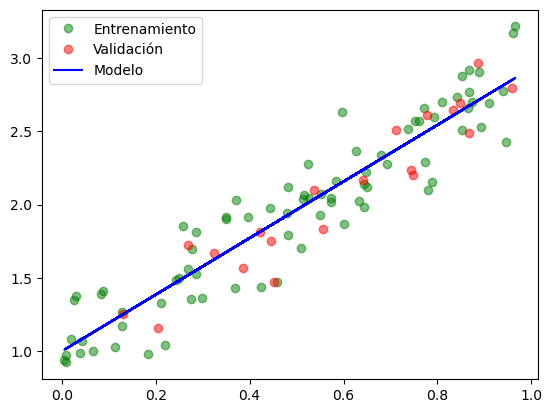

In [17]:
# Se grafica el modelo con los datos
def plot_data_model(x_train, y_train, x_val, y_val, a_numpy, b_numpy):
    """ 
    Grafica los datos y el modelo en dos dimensiones.
    param: x_train, y_train. Datos de entrenamiento.
    param: x_val, y_val. Datos para la validación.
    param: a_numpy, b_numpy. Los parámetros ajustados del modelo. 
    return: sin valor de retorno. 
    """    

    
    plt.clf()
    plt.plot(x_train, y_train, 'go', label='Entrenamiento', alpha=0.5)
    plt.plot(x_val, y_val, 'go', label='Validación', alpha=0.5, color='red')
    plt.plot(x, a_numpy + b_numpy * x, label='Modelo', linestyle='-', color='blue') 
    plt.legend(loc='best')
    plt.show()

# Conversión de variables a numpy
a_numpy = a.detach().numpy()
b_numpy = b.detach().numpy()

plot_data_model(x_train, y_train, x_val, y_val, a_numpy, b_numpy)

In [18]:
# Cálculo del gradiente, la pérdida y actualización de a y b con Pytorch

# Se genera nuevamente a y b
torch.seed()
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

# Factor de aprendizaje 
lr = 1e-1

# Cantidad de veces que se van a ajustar los pesos
n_epochs = 1000

# Convergencia 
for epoch in range(n_epochs):

    # Salida de la función 
    yhat = a + b * x_train_tensor
    
    #Cálculo de la pérdida 
    error = y_train_tensor - yhat
    
    #Error cuadrático medio (MSE)
    loss = (error ** 2).mean()
    
    # El gradiente
    # Se uiliza PyTorch con la función BACKWARDS a partir de la perdida
    loss.backward()
    
    # Ya no tenemos que calcular manualmente los gradientes:
    #a_grad = -2 * error.mean()
    #b_grad = -2 * (x_train_tensor * error).mean()
    
    print("Gradiente de a", a.grad)
    print("Gradiente de b", b.grad)
    
    # Se actualiza los parámetros 
    # Se necesita la opción NO_GRAD para no afectar el grafo de computación dinámica 
    # que mantiene Pytorch.
    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad
    
    # Es necesario limpiar los gradientes para realizar otra corrida.
    a.grad.zero_()
    b.grad.zero_()

print("Valor de a:", a)
print("Valor de b",  b)

Gradiente de a tensor([-2.2558])
Gradiente de b tensor([-1.4946])
Gradiente de a tensor([-1.6560])
Gradiente de b tensor([-1.1711])
Gradiente de a tensor([-1.2083])
Gradiente de b tensor([-0.9288])
Gradiente de a tensor([-0.8743])
Gradiente de b tensor([-0.7470])
Gradiente de a tensor([-0.6251])
Gradiente de b tensor([-0.6105])
Gradiente de a tensor([-0.4394])
Gradiente de b tensor([-0.5079])
Gradiente de a tensor([-0.3010])
Gradiente de b tensor([-0.4305])
Gradiente de a tensor([-0.1980])
Gradiente de b tensor([-0.3720])
Gradiente de a tensor([-0.1214])
Gradiente de b tensor([-0.3277])
Gradiente de a tensor([-0.0645])
Gradiente de b tensor([-0.2939])
Gradiente de a tensor([-0.0224])
Gradiente de b tensor([-0.2680])
Gradiente de a tensor([0.0087])
Gradiente de b tensor([-0.2480])
Gradiente de a tensor([0.0317])
Gradiente de b tensor([-0.2324])
Gradiente de a tensor([0.0484])
Gradiente de b tensor([-0.2201])
Gradiente de a tensor([0.0606])
Gradiente de b tensor([-0.2104])
Gradiente de a

Gradiente de b tensor([-0.0015])
Gradiente de a tensor([0.0008])
Gradiente de b tensor([-0.0014])
Gradiente de a tensor([0.0008])
Gradiente de b tensor([-0.0014])
Gradiente de a tensor([0.0007])
Gradiente de b tensor([-0.0014])
Gradiente de a tensor([0.0007])
Gradiente de b tensor([-0.0014])
Gradiente de a tensor([0.0007])
Gradiente de b tensor([-0.0014])
Gradiente de a tensor([0.0007])
Gradiente de b tensor([-0.0013])
Gradiente de a tensor([0.0007])
Gradiente de b tensor([-0.0013])
Gradiente de a tensor([0.0007])
Gradiente de b tensor([-0.0013])
Gradiente de a tensor([0.0007])
Gradiente de b tensor([-0.0013])
Gradiente de a tensor([0.0007])
Gradiente de b tensor([-0.0013])
Gradiente de a tensor([0.0007])
Gradiente de b tensor([-0.0013])
Gradiente de a tensor([0.0007])
Gradiente de b tensor([-0.0012])
Gradiente de a tensor([0.0007])
Gradiente de b tensor([-0.0012])
Gradiente de a tensor([0.0006])
Gradiente de b tensor([-0.0012])
Gradiente de a tensor([0.0006])
Gradiente de b tensor([-0

Gradiente de a tensor([4.7199e-06])
Gradiente de b tensor([-8.6725e-06])
Gradiente de a tensor([4.6175e-06])
Gradiente de b tensor([-8.5775e-06])
Gradiente de a tensor([4.5020e-06])
Gradiente de b tensor([-8.4946e-06])
Gradiente de a tensor([4.3921e-06])
Gradiente de b tensor([-8.4033e-06])
Gradiente de a tensor([4.2450e-06])
Gradiente de b tensor([-8.3419e-06])
Gradiente de a tensor([4.1341e-06])
Gradiente de b tensor([-8.2515e-06])
Gradiente de a tensor([4.2720e-06])
Gradiente de b tensor([-8.0401e-06])
Gradiente de a tensor([4.0978e-06])
Gradiente de b tensor([-8.0019e-06])
Gradiente de a tensor([4.2161e-06])
Gradiente de b tensor([-7.7952e-06])
Gradiente de a tensor([4.1248e-06])
Gradiente de b tensor([-7.6955e-06])
Gradiente de a tensor([4.1146e-06])
Gradiente de b tensor([-7.5884e-06])
Gradiente de a tensor([4.1034e-06])
Gradiente de b tensor([-7.4701e-06])
Gradiente de a tensor([4.0866e-06])
Gradiente de b tensor([-7.3509e-06])
Gradiente de a tensor([4.1034e-06])
Gradiente de b 

/tmp/ipykernel_9704/24425982.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(x_val, y_val, 'go', label='Validación', alpha=0.5, color='red')


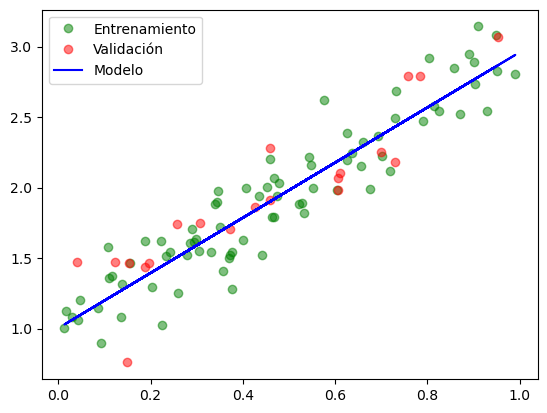

In [53]:
# Conversión de variables a numpy
a_numpy = a.detach().numpy()
b_numpy = b.detach().numpy()

plot_data_model(x_train, y_train, x_val, y_val, a_numpy, b_numpy)

# c) Uso de optimizadores 

PyTorch actualiza los parámetros por medio de optimizadores como Stochastic Gradient Descent (SGD) o Adam.

El optimizador toma los parámetros que se desea actualizar, el resultado del cálculo de los gradientes, el factor de aprendizaje y otros hiperparámetros y realiza las actualizaciones a través del método step().

Además, no es necesario inicializar los gradientes uno por uno, se utiliza la función zero_grad () del optimizador.


In [19]:
# Ejemplo modificado usando el optimizador Stochastic Gradient Descent (SDG)
torch.seed()
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

print("a y b aleatorios")
print(a, b)

# Factor de aprendizaje
lr = 1e-1
n_epochs = 1000

# Definición de un optimizador de descenso de gradiente estocástico (SGD) 
# para actualizar los parámetros a y b con un factor de aprendizaje lr.
optimizer = optim.SGD([a, b], lr=lr)

# Ciclo de convergencia de los parámetros
for epoch in range(n_epochs):
    
    #Cálculo de la salida 
    yhat = a + b * x_train_tensor
    
    #error cuadrático medio (MSE)
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    #print("Pérdida", loss)
    loss.backward()    
    
    # Se elimina la actualiación manual de los parámetros
    # with torch.no_grad():
    #     a -= lr * a.grad
    #     b -= lr * b.grad
    optimizer.step()
    
    # se inicializan los gradientes de todas las variables.
    optimizer.zero_grad()

print("a y b optimizados con descenso de gradiente")    
print(a, b)

a y b aleatorios
tensor([1.4687], requires_grad=True) tensor([-1.0443], requires_grad=True)
a y b optimizados con descenso de gradiente
tensor([1.0021], requires_grad=True) tensor([1.9258], requires_grad=True)


/tmp/ipykernel_9776/24425982.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(x_val, y_val, 'go', label='Validación', alpha=0.5, color='red')


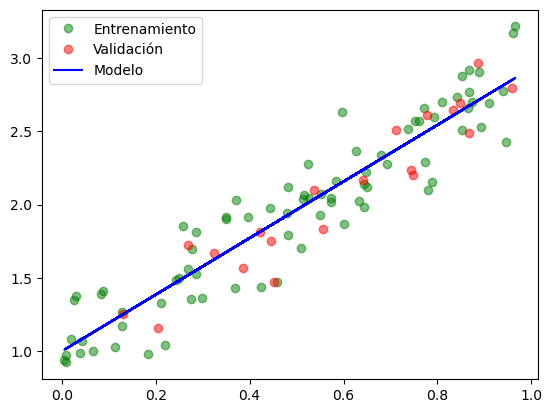

In [20]:
lr# Conversión de variables a numpy
a_numpy = a.detach().numpy()
b_numpy = b.detach().numpy()

plot_data_model(x_train, y_train, x_val, y_val, a_numpy, b_numpy)

# d) Cálculo de la pérdida

PyTorch permite calcular la pérdida de forma automática por medio de muchas funciones implementadas. Dependiendo de la tarea que estemos realizado así debemos elegir la función de pérdida. Como el presente ejemplo es una regresión, podemos utilizar el error cuadrático medio (MSE).


In [21]:
# Cambio del ejemplo implementando el MSE.

torch.seed()
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

# Factor de aprendizaje
lr = 1e-1
n_epochs = 1000

# Definición de la función de pérdida Error Cuadrático Medio 
loss_fn = nn.MSELoss()

# Definición del optimizador
optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor

    # Cálculo de la pérdida
    # error = y_tensor - yhat
    # loss = (error ** 2).mean()
    loss = loss_fn(y_train_tensor, yhat)
    loss.backward()    
    optimizer.stepstep()
    optimizer.zero_grad()
    
print("a", a)
print("b", b)

print("Pérdida", loss)

a tensor([1.0021], requires_grad=True)
b tensor([1.9258], requires_grad=True)
Pérdida tensor(0.0423, grad_fn=<MseLossBackward0>)


In [9]:
print(lr)

0.1


/tmp/ipykernel_9704/24425982.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(x_val, y_val, 'go', label='Validación', alpha=0.5, color='red')


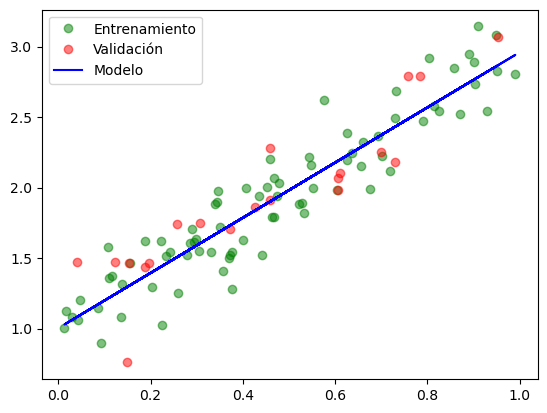

In [57]:
# Graficación de los datos y el modelo resultante

# Conversión de variables a numpy
a_numpy = a.detach().numpy()
b_numpy = b.detach().numpy()

plot_data_model(x_train, y_train, x_val, y_val, a_numpy, b_numpy)

**Referencias**

[1] Godoy, D. (2019). Understanding PyTorch with an example: a step-by-step tutorial. Recuperado de https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e

[2] Bishop (2006). Pattern Recognition and Machine Learning. Disponible en  http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf

[3] Rao, D., McMahan, B. (2019). Natural Language Processing with PyTorch. O'Reilly Media, Inc.

